# classifier 1 : Neural Network 
# classifier 2 : Naive Bayes Classifier
# classifier 3 : Adaboost

                                           Assignment 2

In [46]:
import os
import warnings 
warnings.filterwarnings("ignore")
dog_images=r'output folder'

from skimage import filters
from skimage import io,color
from skimage import exposure
import numpy as np

def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

hist_images = []
labels = []
for index,breed in enumerate(os.listdir(dog_images)):
    image_folder=os.path.join(dog_images,breed)
    for image in os.listdir(image_folder):
        img    = io.imread(os.path.join(image_folder,image.strip()))
        img=color.rgb2gray(img)
        sobel_img = angle(filters.sobel_h(img),filters.sobel_v(img))
        hist,_=exposure.histogram(sobel_img, nbins=36)
        hist_images.append(hist)
        labels.append(index)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

hist_images=np.array(hist_images)
labels=np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(hist_images, labels, test_size=0.2,stratify=labels, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [47]:
K = [1,3,5,7,10,20]

### standard 5-fold

In [48]:
from sklearn.model_selection import StratifiedKFold , cross_val_score,KFold
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier


stantrainerrors=[]
stanvalerrors=[]

standardfold = KFold(n_splits=5)
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)    
    t = []
    v = []
    for train, test in standardfold.split(X_train_scaled, y_train):
        xtrain, xval = X_train_scaled[train], X_train_scaled[test]
        ytrain, yval = y_train[train], y_train[test]
        knn.fit(xtrain, ytrain)
        trainpred = knn.predict(xtrain)
        valpred = knn.predict(xval)
        train_acc = accuracy_score(ytrain, trainpred)
        val_acc = accuracy_score(yval, valpred)
        t.append(1 - train_acc)  
        v.append(1 - val_acc) 

    stantrainerrors.append(np.mean(t))
    stanvalerrors.append(np.mean(v))

### stratified 5-fold

In [49]:
stratrainerrors=[]
stravalerrors=[]

Stratified =StratifiedKFold(n_splits=5)
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)    
    t = []
    v = []
    for train, test in Stratified.split(X_train_scaled, y_train):
        xtrain, xval = X_train_scaled[train], X_train_scaled[test]
        ytrain, yval = y_train[train], y_train[test]
        knn.fit(xtrain, ytrain)
        trainpred = knn.predict(xtrain)
        valpred = knn.predict(xval)
        train_acc = accuracy_score(ytrain, trainpred)
        val_acc = accuracy_score(yval, valpred)
        t.append(1 - train_acc)  
        v.append(1 - val_acc) 

    stratrainerrors.append(np.mean(t))
    stravalerrors.append(np.mean(v))

### plot error curves

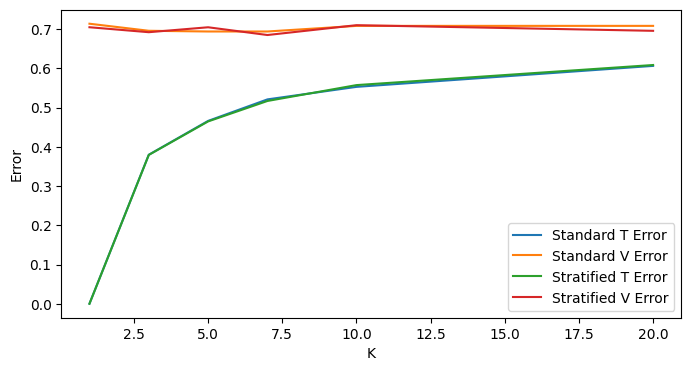

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(K, stantrainerrors, label='Standard T Error')
plt.plot(K, stanvalerrors, label='Standard V Error')
plt.plot(K, stratrainerrors, label='Stratified T Error')
plt.plot(K, stravalerrors, label='Stratified V Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.show()

the lowest mean error : Standard Training error      at k=1 
                        stratified Training error    at k=1 
                        standard validation error    at k=5
                        stratified validation error  at k=7

the model complexity : Less         at k = 1
                       Intermidiate at k = 3,5,7,10
                       high         at k = 20
 

model :  overfits at k = 1   training error is less validation is more.
        underfits at k =20   Great number of neighbours

### Test 

In [53]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)
print("Test Error at k= 7 : \n")
print((1-(accuracy_score(y_test,pred))))

Test Error at k= 7 : 

0.6928571428571428


MLPClassifier(hidden_layer_sizes=(10, 10, 10))




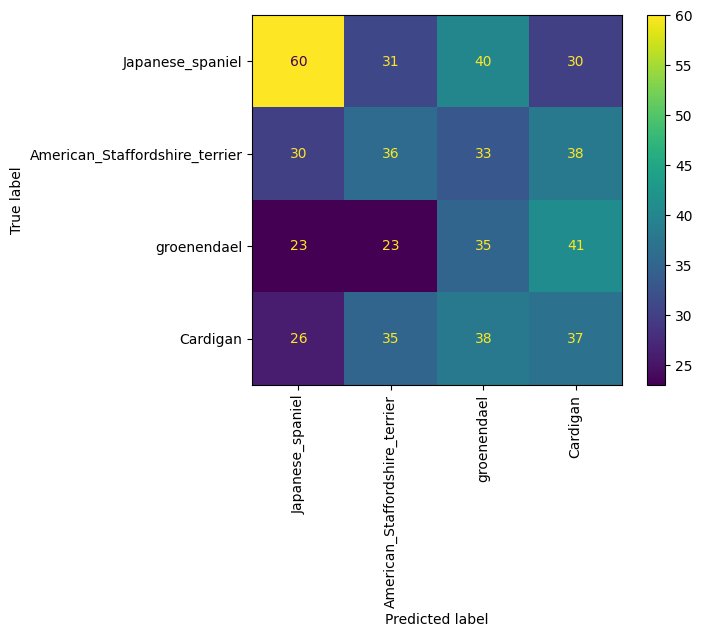

GaussianNB()




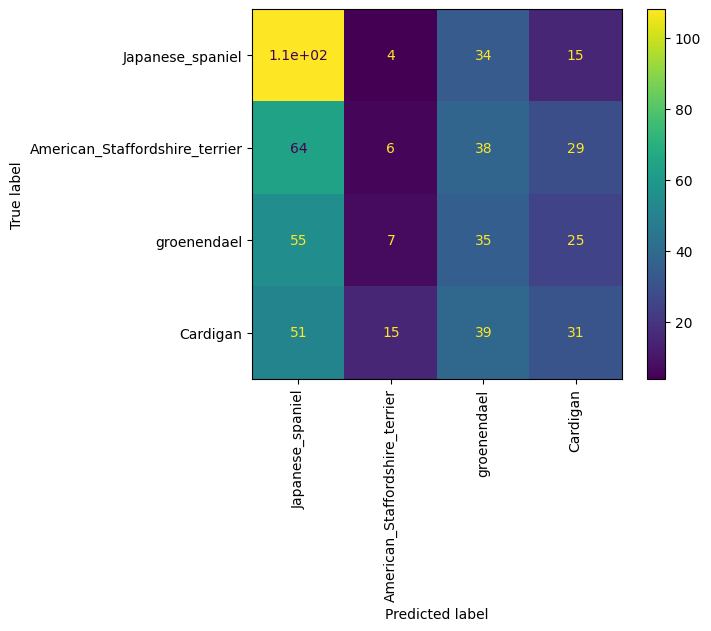

AdaBoostClassifier()




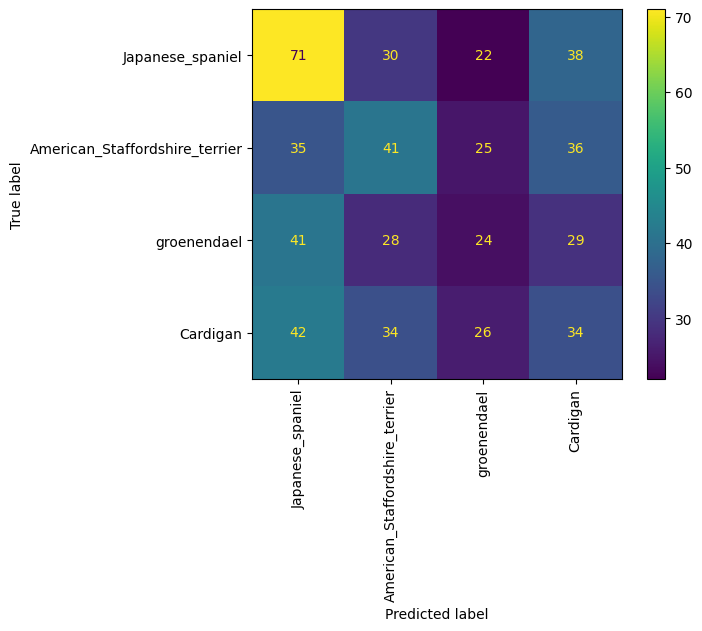

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

neural_network=MLPClassifier(hidden_layer_sizes=(10,10,10))
Naive_bayes=GaussianNB()
Ada_boost= AdaBoostClassifier()


mean_validation_accuracies = []
test_accuracies = []
f1_scores = []


for classifier in [neural_network,Naive_bayes,Ada_boost]:
    true,predict,cm,val_a=[],[],[],[]
    print(str(classifier)+"\n\n")
    for train, test in Stratified.split(X_train_scaled, y_train):
        xtrain, xval = X_train_scaled[train], X_train_scaled[test]
        ytrain, yval = y_train[train], y_train[test]
        
        classifier.fit(xtrain, ytrain)
        pred_labels= classifier.predict(xval)
        true.extend(yval)
        predict.extend(pred_labels)
      
        val_accuracy = accuracy_score(yval, pred_labels)
        val_a.append(val_accuracy)
        
    meanval = np.mean(val_a)
    mean_validation_accuracies.append(meanval)
    
    test_acc = accuracy_score(y_test, classifier.predict(X_test_scaled))
    test_accuracies.append(test_acc)

    f1 = f1_score(y_test, classifier.predict(X_test_scaled), average='weighted')
    f1_scores.append(f1)
    
    
    cm.append(confusion_matrix(true, predict))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm), display_labels = ['Japanese_spaniel','American_Staffordshire_terrier',
 'groenendael', 'Cardigan'] )
    cm_display.plot(xticks_rotation=90)
    plt.show()


### i see more number in diagonal for ada boost classifer

In [55]:
clf=['neural_network','naive_bayes','ada_boost']

In [56]:
for classifier_name, mean_val_accuracy, test_accuracy, f1 in zip(clf, mean_validation_accuracies, test_accuracies, f1_scores):
    print(f"{classifier_name}:")
    print(f"Mean Validation Accuracy: {mean_val_accuracy}")
    print(f"Test Set Accuracy: {test_accuracy}")
    print(f"F-measure: {f1}")

best_method_val_accuracy = clf[np.argmax(mean_validation_accuracies)]
best_method_test_accuracy = clf[np.argmax(test_accuracies)]
best_method_f1 = clf[np.argmax(f1_scores)]

print("Best method based  \n ")
print(f"mean validation accuracy: {best_method_val_accuracy}")
print(f"test set accuracy: {best_method_test_accuracy}")
print(f"F-measure: {best_method_f1}")


neural_network:
Mean Validation Accuracy: 0.3022522522522523
Test Set Accuracy: 0.37142857142857144
F-measure: 0.35585674142065127
naive_bayes:
Mean Validation Accuracy: 0.3237934362934363
Test Set Accuracy: 0.39285714285714285
F-measure: 0.3399077113362828
ada_boost:
Mean Validation Accuracy: 0.30558236808236805
Test Set Accuracy: 0.37857142857142856
F-measure: 0.3779056079647695
Best method based  
 
mean validation accuracy: naive_bayes
test set accuracy: naive_bayes
F-measure: ada_boost


##### From the above we can conclude that 
navie_bayes is best for mean validation accuracy,
navie_bayes is best for test set accuracy,
ada_boost is best for F-Measure

References:
       https://scikit-learn.org/stable/user_guide.html
       
       https://scikit-learn.org/stable/modules/cross_validation.html
       
       https://www.w3schools.com/python/python_ml_confusion_matrix.asp